# Data chunking and image generation

For this project we are using Python, and Jupyter Notebooks hosted on Google Colab. Any Jupyter engine will can be used, but it will require adjustmets to this initial setup to be able to access the raw data and the helper tools. 

To keep the notebook clean, all the implementation details are hidden in a set of helper functions in the file `deeppredict_tools.py`

### Prerequisites for running this Notebook on Google Colab 

We need to mount a Google Drive folder called `deeppredict`, which has the same structure and contents as the repository at https://github.com/dimitardi/deep-predict. 

And the matlab raw data files in the subfolder `DEEPPREDICT_HOME/dataset` (see `deeppredict_0_download_raw_data.ipynb` for how to download these files)

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

DEEPPREDICT_HOME = '/content/gdrive/My Drive/deeppredict'

# add the home folder to the python path to be able to import and use the included code
import sys
sys.path.append(DEEPPREDICT_HOME)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
!pip install --upgrade -q -r '/content/gdrive/My Drive/deeppredict/requirements.txt'

import skimage as sk
# explicitly check the sci-kit image version
# currently colab has the 0.13 by default, which is too old. It should be at least >= 0.14
sk.__version__

'0.14.2'

### How does the input signal look like

We will use the DE (drive end accelerometer) raw data, which is a time series of acceleration values for a bearing:
- under a specific rotational load, 
- and having a specific type of fault (or no fault) 

Here is an example plot of how these "signals" looks like for a bearing at a load of 1797 RPM (raw data file with index "0")

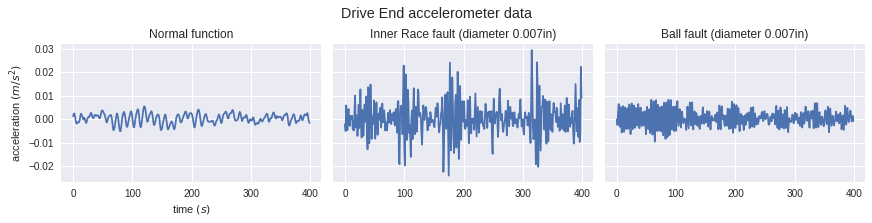

In [3]:
from deeppredict_tools import time_signal

# code=DE - drive end accelerometer data
normal_sig = time_signal(file='Normal_0', code='DE')
ir_sig = time_signal(file='IR007_0', code='DE') 
b_sig = time_signal(file='B007_0', code='DE') 

range_of_samples = range(0,400)

# plotting
import matplotlib.pyplot as plt
fig, (plt1, plt2, plt3) = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(12,3), constrained_layout=True)
plt1.set_xlabel("time $(s)$")
plt1.set_ylabel("acceleration $(m/s^2)$")
plt1.set_title('Normal function')
plt1.plot(normal_sig[range_of_samples])
plt2.set_title('Inner Race fault (diameter 0.007in)')
plt2.plot(ir_sig[range_of_samples])
plt3.set_title('Ball fault (diameter 0.007in)')
plt3.plot(b_sig[range_of_samples])
fig.suptitle('Drive End accelerometer data')
fig.show()

### Generate the image set

Let's first generate the images, on which the Convolutional Neural Network will be trained.

We'll divide the signal in chunks of size `chunk_size`, and take a `number_of_chunks` from all the available. A chunk is simply a sequential subset of the time series data with a fixed length - the `chunk_size`. Every chunk is distinct - there are no overlapping samples in different chunks. 

This method of tumbling time windowing is elaborated on [here](https://blog.codecentric.de/en/2018/10/window-functions-in-stream-analytics/)

Further parameters we can play with and try to find the combination that works best are:
- `image_types`: this is the type of image we generate. It can be a spectrogram, a scalogram or a q-transform. We will use a spectrogram for this case, but this can easily be changed here.

- `image shape` controls the quality of the image (number of pixels) and thus indirectly the complexity of the first convolutional layer of the network.

- `noise_scale` can be used to add some amount of noise to the signal to see how this would affect the accuracy. We'll first start without a noise.

- `shuffle_chunks_accros_time` if True, will randomise the order of the chunks. Otherwise we will be taking the chunks sequentially. This makes sense if we have a very long signal and want diversify across time. Otherwise the chunks will represent sequential time intervals of data. 


In [0]:
from deeppredict_tools import ImageType

chunk_size = 1200
number_of_chunks=1400
image_types=[ImageType.SPECTROGRAM]
image_shape = (96, 96)
shuffle_chunks_across_time=True

Now we are ready to generate the image set. The following function will generate a `image_type` type of RGBA encoded image for every chunk of data, for every of the three types of data we are going to consider. 

It will then save these values as a numpy array for performance.
> actually it's a dictionary of numpy arrays. The keys are the labels ("N", "IR", and "B") and under each label - the set of images corresponding to this type of data

In [5]:
from deeppredict_tools import create_image_by_label_database, ImageType

create_image_by_label_database(
    number_of_chunks=number_of_chunks, 
    chunk_size=chunk_size, 
    image_types=image_types, 
    image_shape=image_shape, 
    shuffle_chunks_across_time=shuffle_chunks_across_time,
    overwrite_existing_file=True)


100%|██████████| 1400/1400 [00:15<00:00, 92.84it/s]


Saving /content/gdrive/My Drive/deeppredict/npy_dataset/images_by_labels_for_cnn__chunks1400_size1200_typesSP_timeshuffled_shape96-96.npy


The function will create a file with a parametrised name that can also be used later.

Let's load it up now and take a look at the images.

In [6]:
from deeppredict_tools import load_images_by_labels_by_params, ImageType

images_by_labels = load_images_by_labels_by_params(
    chunk_size=chunk_size, 
    number_of_chunks=number_of_chunks,     
    image_types=image_types, 
    image_shape=image_shape,
    chunks_are_shuffled_across_time=shuffle_chunks_across_time)

Successfully loaded file /content/gdrive/My Drive/deeppredict/npy_dataset/images_by_labels_for_cnn__chunks1400_size1200_typesSP_timeshuffled_shape96-96.npy


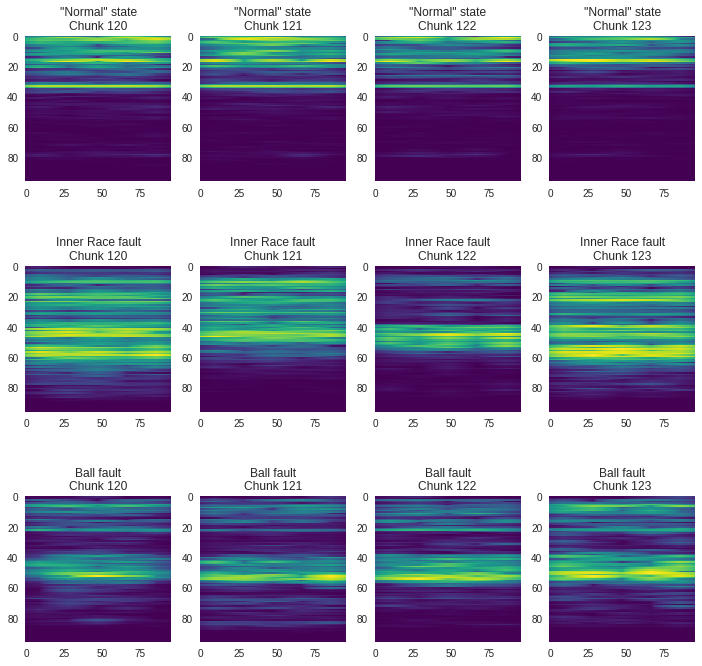

In [7]:
import matplotlib.pyplot as plt

offset = 120  # start at the {offset} chunk, somewhere within the waste of images

normal_images = images_by_labels['n']
ir_images = images_by_labels['ir']
b_images = images_by_labels['b']

plt.rcParams["axes.grid"] = False
fig = plt.figure(figsize=(12, 12))
for i in range(0, 4):  # plot so many images in a row
    plt.subplot(3, 4, i+1, title=f'"Normal" state\nChunk {offset+i}')
    plt.imshow(normal_images[offset+i])
for i in range(4, 8):  # plot so many images in a row
    plt.subplot(3, 4, i+1, title=f'Inner Race fault\nChunk {offset+i-4}')
    plt.imshow(ir_images[offset+i-4])
for i in range(8, 12):  # plot so many images in a row
    plt.subplot(3, 4, i+1, title=f'Ball fault\nChunk {offset+i-8}')
    plt.imshow(b_images[offset+i-8])
fig.show()